Adam Peetz<br>
MSDS650 Week 7 Assignment <br>
Regis University<br>

# BBC Text Analytics 

Natural Language Processing gives computers the ability to understand concepts in human generated text and language (IBM, 2020). It is at the core of technology that performs tasks like speech recognition and sentiment analysis. This notebook contains code that will demonstrate key topics in natural language processing on a database of 2225 documents from the BBC news website. These documents were collected from 5 subject areas and were written between 2004 and 2005. The following NLP subjects will be explored in this notebook:
 1. Data Preparation
 2. Lemmatization
 3. Word Count Frequencies
 4. Word Clouds for Visualization
 5. N-Grams
 6. Part Of Speech Tagging
 7. Topic Modeling



In [18]:
# load required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.collocations import TrigramCollocationFinder
from nltk.metrics import TrigramAssocMeasures
from nltk.tag import pos_tag
from collections import Counter
import gensim
import gensim.corpora as corpora
import pyLDAvis.gensim
import pickle 
import pyLDAvis
from gensim.models import CoherenceModel
from PIL import Image
from os import path
import os
import sqlite3

#download nltk reference libraries
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#warning handling
import warnings
warnings.filterwarnings("ignore")

#visualization settings
%matplotlib inline
sns.set() 

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\adamg\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adamg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
#create df from csv
bbc_df = pd.read_csv('assign_wk7/bbc.csv',delimiter=',')

In [20]:
#sample DF
bbc_df.head()

,id,news,type
0,0,UK economy facing 'major risks'\n \n The UK ma...,business
1,1,Aids and climate top Davos agenda\n \n Climate...,business
2,2,Asian quake hits European shares\n \n Shares i...,business
3,3,India power shares jump on debut\n \n Shares i...,business
4,4,Lacroix label bought by US firm\n \n Luxury go...,business


In [21]:
#sample news feature contents
bbc_df.iloc[0]['news']

'UK economy facing \'major risks\'\n \n The UK manufacturing sector will continue to face "serious challenges" over the next two years, the British Chamber of Commerce (BCC) has said.\n \n The group\'s quarterly survey of companies found exports had picked up in the last three months of 2004 to their best levels in eight years. The rise came despite exchange rates being cited as a major concern. However, the BCC found the whole UK economy still faced "major risks" and warned that growth is set to slow. It recently forecast economic growth will slow from more than 3% in 2004 to a little below 2.5% in both 2005 and 2006.\n \n Manufacturers\' domestic sales growth fell back slightly in the quarter, the survey of 5,196 firms found. Employment in manufacturing also fell and job expectations were at their lowest level for a year.\n \n "Despite some positive news for the export sector, there are worrying signs for manufacturing," the BCC said. "These results reinforce our concern over the sec

### Cleaning Text Data

<b>Requirement: Preparation of the text data for analysis</b>

In its raw form, most text data is too messy to be meaningfully processed and it must be cleaned prior to engaging in NLP. Common cleaning techniques for the preparation of text data are; the elimination of stop words, standardization of casing, removal of punctation and integers, as well as any other custom processing that must be done for a specific volume of text.



<b>Requirement: Elimination of stop words</b>

Stop words are commonly used words that must be removed to make an analysis useful. Examples of common stop words in the English language are "the" and "a". These words are used so often that they will usually be the most frequently used words in a volume of text. They must be removed prior to natural language processing, or they will cloud the metrics.

To remove stop words from the text, a library of common stop words can be downloaded from the Natural Language Toolkit (NLTK) and those words removed from the text. There is no universal list of stop words that can remove all the unneeded words from a volume of text. To improve the accuracy of the BBC analysis, a custom list of words was also removed.

Additional Stop Words Removed:
+ ['the','it','he','in','but','like','get','she','him','her','mr','said']

The process of building a custom stop word list is cyclical. In the BBC example, more advanced topic models guide the removal of certain words like "mr" and "said". The removal of these words from the model unearthed different layers of topics as it adjusted the weights of other topics underneath them.


In [22]:
#remove stopwords
stop = stopwords.words('english')
extrastops = stop + ['the','it','he','in','but','like','get','she','him','her']
bbc_df['clean_text'] = bbc_df.news.apply(lambda x: " ".join(w for w in x.split() if w not in extrastops))

<b>Requirement: Clean casing</b>

NLTK tools see uppercase and lowercase letters as seperate words. To make sure words are only counted once they all need to converted to a common case. All letters in the BBC text have been converted to lowercase to clean them for processing. 

The stop words list needs to be reapplied to remove any uppercase stop words that were missed in the original stop word removal.


In [23]:
#converting to lowercase MSDS650
bbc_df['clean_text'] = bbc_df.clean_text.apply(lambda x: " ".join(x.lower() for x in x.split()))
bbc_df['clean_text'] = bbc_df.clean_text.apply(lambda x: " ".join(w for w in x.split() if w not in extrastops))

<b>Requirement: Clean punctuation</b>

Punctation may need to be removed from the NLP model. While some NLP applications will use punctuation for weight. The applications of NLP in this notebook will require punctuation to be removed.

In [24]:
#removing punctuation MSDS650
bbc_df['clean_text'] = bbc_df.clean_text.str.replace('-',' ')
bbc_df['clean_text'] = bbc_df.clean_text.str.replace('[^\w\s]','')
bbc_df['clean_text'] = bbc_df.clean_text.apply(lambda x: " ".join(w for w in x.split() if w not in extrastops))

<b>Requirement: Clean digits</b>

Digits may need to be removed from the NLP model. Like punctuation, some NLP applications will use digits for weight, however the applications of NLP in this notebook will require digits to be removed.

In [25]:
#removing digits MSDS650
bbc_df['clean_text'] = bbc_df.clean_text.str.replace('\d+','')

<b>Removing single letters</b>

Finally, single letter strings are removed from the text. In the case of the BBC text data, several single letter artifacts remain in the dataset after the other cleaning steps are performed. These are scrubbed out using a lambda function to remove the single letter strings.


In [26]:
#removing letters of specific length MSDS650
bbc_df['clean_text'] = bbc_df.clean_text.apply(lambda x: " ".join(x for x in x.split() if len(x) > 1))

<b>Lemmatization</b>

<b>Create lemmatized text version for alternate analysis</b>

<b>Explain and demonstrate this topic</b>

Lemmatization is the process of converting words to their common base word. An example of this is removing the pluralization "(s)" from the end of words. This can be seen below in row 3 of the data frame sample, where the letter "s" is removed at the end of a word, changing shares to share. The process of lemmatization reduces the morphological variation in the body of text which can be used to improve topic modeling scores.


In [27]:
#lemmatizing text MSDS650
#create lemmatizer object
wordnet_lemmatizer = WordNetLemmatizer()
#apply lemmatizer to pandas dataframe
bbc_df['lemma_text'] = bbc_df.clean_text.apply(lambda x: " ".join(wordnet_lemmatizer.lemmatize(w) for w in x.split()))

In [28]:
#show sample of datadrame after addition of lemmatext
bbc_df.head()

,id,news,type,clean_text,lemma_text
0,0,UK economy facing 'major risks'\n \n The UK ma...,business,uk economy facing major risks uk manufacturing...,uk economy facing major risk uk manufacturing ...
1,1,Aids and climate top Davos agenda\n \n Climate...,business,aids climate top davos agenda climate change f...,aid climate top davos agenda climate change fi...
2,2,Asian quake hits European shares\n \n Shares i...,business,asian quake hits european shares shares europe...,asian quake hit european share share europe le...
3,3,India power shares jump on debut\n \n Shares i...,business,india power shares jump debut shares indias la...,india power share jump debut share india large...
4,4,Lacroix label bought by US firm\n \n Luxury go...,business,lacroix label bought us firm luxury goods grou...,lacroix label bought u firm luxury good group ...


### Word Counts

<b>Requirement: 10 most used words</b>

After processing, the top 10 words used in the text are: 
 - would : 2581
 - also : 2156
 - year : 2088
 - new : 1978
 - people : 1970
 - us : 1963
 - one : 1863
 - could : 1510
 - last : 1394 
 - first : 1355



In [29]:
#MSDS600
freq = pd.Series(' '.join(bbc_df.clean_text).split()).value_counts().to_dict()

#create keys and values for visualization
topkeys = list(freq.keys())[:10]
topvals = list(freq.values())[:10]

[Text(0.5, 1.0, 'Top 10 Most used Words')]

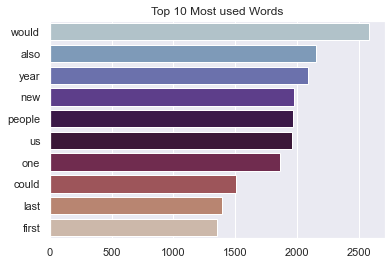

In [30]:
#plot most used words
sns.barplot(x=topvals,y=topkeys,palette="twilight").set(title='Top 10 Most used Words')

<b>Requirement: 10 least used words </b>

The least used words all have an occurrence of 1 time. In the dataset, there are many words that were only used once, including things that look like spelling errors, like "ofsquabbling". A sample of single use words is:
- brunos
- plunges
- nibbled
- inconvenient
- hove
- unequal
- cbe
- kayitesi
- ofsquabbling
- bluebirds


In [31]:
#create keys and values for visualization
botkeys = list(freq.keys())[-10:]
botvals = list(freq.values())[-10:]

[Text(0.5, 1.0, '10 Least Used Words')]

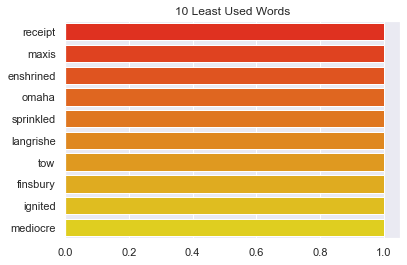

In [32]:
#plot least used words
sns.barplot(x=botvals,y=botkeys,palette="autumn").set(title='10 Least Used Words')

<b>Requirement: Lemmatized 10 most used words</b>

The process of lemmatization changes the list of top words. After lemmatization, year becomes the most used word in the dataset. Concepts of game and time also rise up the list. Interestingly, the process of lemmatization has clipped the word "us" into "u", which is not necessarily a desirable change.
- year : 3311
- would : 2581
- also : 2156
- people : 2045
- new : 1978
- u : 1963
- one : 1935
- time : 1627
- could : 1510
- game : 1492


In [33]:
#MSDS600
lemma_freq = pd.Series(' '.join(bbc_df.lemma_text).split()).value_counts().to_dict()

#create keys and values for visualization
lemmatopkeys = list(lemma_freq.keys())[:10]
lemmatopvals = list(lemma_freq.values())[:10]

[Text(0.5, 1.0, 'Top 10 Lemmatized Words')]

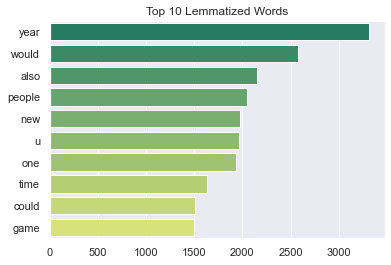

In [34]:
#plot most used words
sns.barplot(x=lemmatopvals,y=lemmatopkeys,palette="summer").set(title='Top 10 Lemmatized Words')

<b>Requirement: Lemmatized 10 least used words </b>

Similar to the unlemmatized set, the least used words in the lemmatized text all have an occurrence of 1 time. In the lemmatized dataset, there are many words that were only used once, including:
- scathe
- athleticism
- paddington
- intuition
- ped
- cossins
- nspcc
- ostentowski
- mu
- broadside


In [35]:
#create keys and values for visualization
lemmabotkeys = list(lemma_freq.keys())[-10:]
lemmabotvals = list(lemma_freq.values())[-10:]

[Text(0.5, 1.0, 'Bottom 10 Lemmatized Words')]

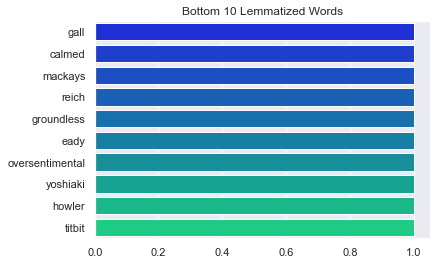

In [36]:
#plot least used words
sns.barplot(x=lemmabotvals,y=lemmabotkeys,palette="winter").set(title='Bottom 10 Lemmatized Words')

<b>Requirement: Generate a world cloud for the text</b>

One way to visualize the use of words in text is with a word cloud. A word cloud shows a summary of the most used words weighed by their importance. For the BBC example text, the prominence of the word year is dramatically highlighted. This illustrates the BBC's focus on reporting current events.


In [37]:
#MSDS650
#create word cloud object from lemmatext
wc = WordCloud(width=1000, height=600, max_words=200).generate_from_frequencies(lemma_freq)

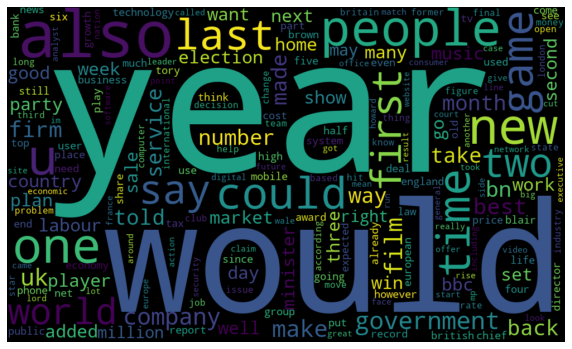

In [38]:
#MSDS650
#plot word cloud object
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

<b>Requirement: Generation of n-grams </b>

N-grams are collections of the most used word combinations of "n" digit length. The most commonly reviewed n-gram types are bi-grams, two-word combinations, and tri-grams, three word combinations. N-gram comprehension is important for several reasons. First, some n-grams should be taken as a single word or representation of a topic, things like BBC Radio or Tony Blair are two words that represent a single idea. N-grams can also be used to understand topics and sentiments occurring in the text. Some thematical bi-grams in the BBC text are "human rights" or "general election". Finally, N-grams can be used for word prediction.  (Kumar, 2017)


<b>Requirement: Demonstrate Bigrams</b>


In [39]:
#MSDS650
#create tokens
tokens = ' '.join(bbc_df.clean_text).split()

In [40]:
#MSDS650
# create bigrams
ngrams_2 = nltk.bigrams(tokens)

# freq distribution for these
freq_2grams = pd.Series(ngrams_2).value_counts().to_dict()
list(freq_2grams.items())[:20]

[(('last', 'year'), 384),
 (('told', 'bbc'), 348),
 (('year', 'old'), 299),
 (('prime', 'minister'), 276),
 (('chief', 'executive'), 200),
 (('bbc', 'news'), 178),
 (('general', 'election'), 172),
 (('tony', 'blair'), 164),
 (('last', 'week'), 164),
 (('bn', 'bn'), 163),
 (('six', 'nations'), 162),
 (('new', 'york'), 161),
 (('first', 'time'), 153),
 (('number', 'one'), 140),
 (('years', 'ago'), 128),
 (('human', 'rights'), 119),
 (('last', 'years'), 117),
 (('michael', 'howard'), 115),
 (('bbc', 'radio'), 114),
 (('next', 'year'), 107)]

<b>Requirement: Demonstrate Trigrams</b>

In [41]:
# creating the bigrams
ngrams_3 = nltk.trigrams(tokens)

# freq distribution for these
freq_3grams = pd.Series(ngrams_3).value_counts().to_dict()
list(freq_3grams.items())[:20]

[(('told', 'bbc', 'news'), 147),
 (('bbc', 'news', 'website'), 94),
 (('told', 'bbc', 'radio'), 76),
 (('leader', 'michael', 'howard'), 55),
 (('million', 'dollar', 'baby'), 50),
 (('radio', 'today', 'programme'), 49),
 (('told', 'bbc', 'sport'), 48),
 (('bbc', 'radio', 'today'), 47),
 (('tory', 'leader', 'michael'), 41),
 (('next', 'general', 'election'), 39),
 (('prime', 'minister', 'tony'), 32),
 (('leader', 'charles', 'kennedy'), 32),
 (('two', 'years', 'ago'), 28),
 (('chancellor', 'gordon', 'brown'), 27),
 (('coach', 'andy', 'robinson'), 27),
 (('minister', 'tony', 'blair'), 26),
 (('world', 'number', 'one'), 26),
 (('london', 'stock', 'exchange'), 25),
 (('digital', 'music', 'players'), 23),
 (('deputy', 'prime', 'minister'), 23)]

<b>Requirement: Part of speech tagging </b>

Part of speech tagging identifies words with their part of speech title, noun or verb for example. A use case for part of speech tagging is in predictive text models. The way this works is sentences have common patterns and structures based around the number and position of parts of speech. These can be combined into a Markov model that assists with prediction or the generation of spoken language. (Pykes, 2021) Part of speech tagging has been conducted on the BBC news text dataset below using code from this week’s MSDS650 lesson.


In [42]:
#MSDS 650
# create POS tags list with tokens
pos_tags = pos_tag(tokens)
pos_tags[:20]

[('uk', 'JJ'),
 ('economy', 'NN'),
 ('facing', 'VBG'),
 ('major', 'JJ'),
 ('risks', 'NNS'),
 ('uk', 'JJ'),
 ('manufacturing', 'NN'),
 ('sector', 'NN'),
 ('continue', 'VBP'),
 ('face', 'VBP'),
 ('serious', 'JJ'),
 ('challenges', 'NNS'),
 ('next', 'IN'),
 ('two', 'CD'),
 ('years', 'NNS'),
 ('british', 'JJ'),
 ('chamber', 'VBP'),
 ('commerce', 'NN'),
 ('bcc', 'NN'),
 ('groups', 'NNS')]

<b>After parts of speech are identified, they can be counted</b>

In [43]:
#MSDS650
#create count for POS tokens
Counter([j for i,j in pos_tag(tokens)])

Counter({'JJ': 87157,
         'NN': 166077,
         'VBG': 20040,
         'NNS': 64426,
         'VBP': 24987,
         'IN': 6897,
         'CD': 6820,
         'VBD': 26219,
         'RB': 23733,
         'VBN': 13054,
         'VB': 9769,
         'JJS': 2377,
         'VBZ': 9058,
         'JJR': 1777,
         'RBR': 1156,
         'WP$': 123,
         'FW': 626,
         'MD': 5354,
         'PRP': 2004,
         'DT': 812,
         'NNP': 682,
         'CC': 283,
         'RP': 447,
         'WRB': 32,
         'WP': 41,
         'POS': 5,
         'WDT': 67,
         'NNPS': 66,
         'RBS': 150,
         'PDT': 6,
         "''": 3,
         'PRP$': 11,
         'UH': 10,
         'EX': 1,
         'TO': 1})

<b>Requirement: Create a topic model of the text  </b>

Topic modeling is a way to abstract and show relationships of ideas occurring in a volume of text. Topic modeling puts together all of the other pieces of NLP to drive deep insights into what is occurring.  Latent Dirichlet Allocation (LDA) is commonly used to construct topic models. In the case of text topic modeling, Latent Dirichlet Allocations (LDA) are collections of topic relationships that are clustered based on the strength of the relationship to a central topic. An LDA model can be constructed for the BBC text using the Gensim library.


In [44]:
#MSDS650
lem_ls = list(bbc_df.lemma_text.apply(lambda x: list(x.split())))

In [45]:
# Create Dictionary
id2word = corpora.Dictionary(lem_ls)

# Term Document Frequency Corpus
#texts = lem_ls
corpus = [id2word.doc2bow(post) for post in lem_ls]

In [46]:
# Build Basic LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

<b>Requirement: Test the accuracy of your model  </b>

The accuracy of an LDA model can be judged using a coherence score. A coherence score can be calculated using the coherence model function from the Gensim library. A coherence model attempts to explain the strength of relationships in a volume of text using variables like the number of times a word occurs and the number of documents that word occurs in. The LDA used in this notebook is a multicore model. Multicore LDA results are never reproducible between runs, due to the way multicore runs are distributed between processors. 

<b>Approximate coherence score of 10 topic model: </b><br>
42%


In [47]:
# compute the coherence score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=lem_ls, 
                                     dictionary=id2word, 
                                     coherence='c_v')

# retreive the coherence_scores
coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4587753742689643


<b>Requirement: Find the optimal number of topics  </b>

The coherence score can be used to fine tune the hyperparameters of a LDA model. The most important hyperparameter for a LDA topic model is the number of topics. To fine tune the model, different iterations need to be created and scored using different numbers of topics. After several runs the most consistent highest performing topic number was 7.

<b>Optimum topic numbers and coherency:</b><br>
- 7 topics with around 48-49% accuracy


In [48]:
#MSDS650

PYTHONHASHSEED=0

#iterate through topic models with different topic sizes
scores = []
for i in range(2,15):
    print(f'Calcuting for {i} topics')
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=i, 
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
    # compute the coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=lem_ls, 
                                         dictionary=id2word, 
                                         coherence='c_v')

    # retreive the coherence_scores
    coherence_lda = coherence_model_lda.get_coherence()
    
    scores.append((i,coherence_lda))

Calcuting for 2 topics
Calcuting for 3 topics
Calcuting for 4 topics
Calcuting for 5 topics
Calcuting for 6 topics
Calcuting for 7 topics
Calcuting for 8 topics
Calcuting for 9 topics
Calcuting for 10 topics
Calcuting for 11 topics
Calcuting for 12 topics
Calcuting for 13 topics
Calcuting for 14 topics


In [49]:
# display topic scores
scores

[(2, 0.2658636776540882),
 (3, 0.38829220599120134),
 (4, 0.41274248507121847),
 (5, 0.4256527857878112),
 (6, 0.4058003872838934),
 (7, 0.45139134020938737),
 (8, 0.4492818719985564),
 (9, 0.39816620401087277),
 (10, 0.43726624284908794),
 (11, 0.41985060522629447),
 (12, 0.46100236568954345),
 (13, 0.39245628624502044),
 (14, 0.4548354865179034)]

In [50]:
#create new topic model with optimum number of topics
bf_lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=7, 
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

<b>Requirement: Display your results 2 different ways.  </b>

<b>Requirement: Print the topics and explain any insights at this point.  </b>

The first way to visualize a topic model is with text. A text visualization of topics shows the grouping of topics and the words that have the strongest association to those topics alongside their weights. In the text visualization of the BBC model, we can see topic clouds forming around different clusters of words. Examples of topics selected by the model are people, film, video games, sports, and actions taken by the government.


In [51]:
#https://github.com/susanli2016/NLP-with-Python/blob/master/LDA_news_headlines.ipynb
for idx, topic in bf_lda_model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.009*"people" + 0.008*"film" + 0.007*"music" + 0.005*"user" + 0.005*"year" + 0.005*"new" + 0.005*"best" + 0.005*"one" + 0.005*"also" + 0.004*"phone"
Topic: 1 Word: 0.011*"game" + 0.010*"mobile" + 0.008*"technology" + 0.006*"year" + 0.006*"tv" + 0.006*"phone" + 0.005*"also" + 0.005*"digital" + 0.005*"people" + 0.004*"video"
Topic: 2 Word: 0.008*"year" + 0.006*"game" + 0.006*"first" + 0.005*"win" + 0.005*"time" + 0.005*"two" + 0.005*"one" + 0.005*"last" + 0.004*"second" + 0.004*"final"
Topic: 3 Word: 0.010*"would" + 0.007*"labour" + 0.007*"election" + 0.006*"blair" + 0.005*"party" + 0.005*"say" + 0.005*"minister" + 0.005*"brown" + 0.004*"year" + 0.004*"tory"
Topic: 4 Word: 0.010*"england" + 0.008*"game" + 0.007*"player" + 0.007*"year" + 0.006*"ireland" + 0.005*"first" + 0.005*"wale" + 0.005*"rugby" + 0.004*"half" + 0.004*"time"
Topic: 5 Word: 0.008*"would" + 0.006*"government" + 0.005*"people" + 0.005*"new" + 0.005*"year" + 0.004*"law" + 0.004*"could" + 0.004*"one" + 0.00

<b>Requirement: Display your results 2 different ways.  </b>

<b>Requirement: Graph the topics and explain any insights at this point.  </b>

The second way to visualize a topic model is with a graph. An interactive webpage graphic model can be generated using the pyLDAvis library and Gensim, please reference the included bbc_model_viz.html. <br>

The graphical presentation of a LDA is much more illustrative than a text representation. In this graphical representation all 7 clusters of topics can be explored by hoovering a mouse over them. The sliding relevance metric allows the user to drive deeper into associations of each highlighted topic. As the relevance metric is reduced, more granular detail is revealed about each one of the clusters. In the current topic model, there are three disctinct clusters corresponding to video games and tehcnology, actions of the government, and sports. These clusters are grouped next to similar topics in the model. For example, there is overlap between the topic of government actions in the "year" and the "would" topic which appears to correspond to the potential actions of the labor party during 2004-2005. <br>

A visual representation of a topic model will also show how dissimilar some topics are. In the BBC data, there is a distinct "games" cluster that is separated entirely from the "sports" topic. This is because the word "games" in the BBC text most likely refers to mobile and technological games, rather than turf and ball type pursuits. <br>

The code below will generate a topic model .html page. It is take from this week’s MSDS650 lesson.


In [52]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(bf_lda_model, corpus, id2word)
pyLDAvis.save_html(LDAvis_prepared,'bbc_model_viz.html')

# References

IBM Cloud Education. <i> What is Natural Langauge Processing </i> taken from ibm.com link:
https://www.ibm.com/cloud/learn/natural-language-processing

Kumar, Prachi. 2017. <i> An Introduction to N-grams: What Are They and Why Do We Need Them? </i> taken from blog.xrds.acm.org link https://blog.xrds.acm.org/2017/10/introduction-n-grams-need/

Steven Bird, Ewan Klein, and Edward Loper (2009). Natural Language Processing with Python. O’Reilly Media Inc. https://www.nltk.org/book

Pedregosa et al. 2011. <i>Scikit-learn: Machine Learning in Python,</i>  JMLR 12, taken from scikit-learn.org

Pykes, Kurtis. 2021. <i>Part of speech tagging for begginers</i> from towarddatascience.com link https://towardsdatascience.com/part-of-speech-tagging-for-beginners-3a0754b2ebba#:~:text=Part%2Dof%2Dspeech%20

Rehurek, Radim. 2021. <i>Gensim: Topic moodeling for humans</i> from radimrehurek.com/gensim/index

Waskom ML (2021). seaborn: statistical data visualization. Journal of Open Source Software 6(60): 3021.a